In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib.pyplot as plt

# import helper functions from utils.py:
from utils import tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph

# Planning:

- refactor code / make it more clear
- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### TODOS:
- Fix Lookup Table
- Remove hardcoded num_inducing points (problem: using tf.shape(Z_ph)[0] returns a tensor, variables cannot be initialized with unknown shape)
- Define hyperparameters as variables and add two optimizers with var_lists to optimize with/without hyperparameters 

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

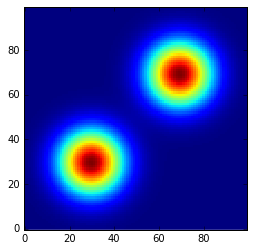

In [3]:
res = 100

xx, yy = np.meshgrid(np.linspace(0, 10, res), np.linspace(0, 10, res))

X = np.array([xx, yy]).transpose(1,2,0).reshape(res**2, 2)
vals = double_blob(X).reshape(res,res)

plt.imshow(vals, interpolation='None', origin='lower')
plt.show()

In [4]:
samples, _, _, _ = get_scp_samples(double_blob, np.array([[0, 10], [0,10]]), 10)

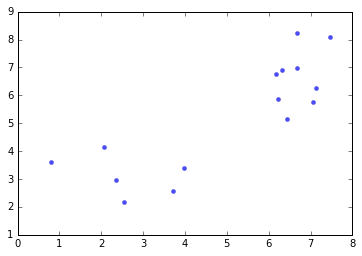

In [5]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.show()

# Variational Approximation

In [6]:
## ######## ##
# PARAMETERS #
## ######## ##
log_dir = 'logs'
max_iterations = 100

ind_point_res = 11

# inducing point location
Zx = np.linspace(1, 9, ind_point_res)[:,na]
Zy = np.linspace(1, 9, ind_point_res)[:,na]

xx, yy = np.meshgrid(Zx, Zy)

Z = np.array([xx, yy]).transpose(1,2,0).reshape(ind_point_res**2, 2)

# X = np.random.rand(10,2)*10

wr_means = []
wr_covar = []


## ######### ##
# BUILD GRAPH #
## ######### ##
tf.reset_default_graph()
lower_bound, merged, Z_ph, u_ph, X_ph, m, S, interesting_gradient = build_graph(Z.shape[0])

with tf.name_scope('optimization'):
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(-lower_bound)
    

#inspected_op = tf.get_default_graph().get_tensor_by_name("KL-divergence/truediv:0")
#interesting_gradient = tf.gradients(lower_bound, [inspected_op])[0]

## ########## ##
# OPTIMIZATION #
## ########## ##
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(log_dir, sess.graph)
    
    S_init_val = sess.run([S])
    # print(S_init_val)
    # print(np.all(np.linalg.eigvals(S_init_val) >= 0))
    
    for i in range(max_iterations):
        _, m_val, S_val, grad_val, summary = sess.run([train_step, m, S, interesting_gradient, merged], feed_dict={Z_ph:Z, u_ph:0.,X_ph:samples})
        writer.add_summary(summary, i)
        
        # print('------------')
        # print(S_val)
        # print(np.min(S_val))
        # print(np.max(S_val))
        # print(np.allclose(S_val, S_val.T))
        # print(np.all(np.linalg.eigvals(S_val) >= 0))
        
        #print(sess.run([S]))
        #print(sess.run([L_vech_grad]))

InvalidArgumentError: indices[11] = 10000 is not in [0, 10000)
	 [[Node: expectation_at_datapoints/Gather_2 = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](expectation_at_datapoints/strided_slice_1, expectation_at_datapoints/add_2)]]

Caused by op 'expectation_at_datapoints/Gather_2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-f3c104a986c2>", line 27, in <module>
    lower_bound, merged, Z_ph, u_ph, X_ph, m, S, interesting_gradient = build_graph(Z.shape[0])
  File "/home/max/Uni/17_18_WiSe/PMAI/pmai-vi-gpmpp/utils.py", line 58, in build_graph
    exp_term = exp_at_datapoints(mu_t_sqr,sig_t_sqr,C)
  File "/home/max/Uni/17_18_WiSe/PMAI/pmai-vi-gpmpp/utils.py", line 153, in exp_at_datapoints
    return tf.reduce_sum(-G(mu_sqr,sig_sqr)+tf.log(mu_sqr/2)-C,axis=1)
  File "/home/max/Uni/17_18_WiSe/PMAI/pmai-vi-gpmpp/utils.py", line 149, in G
    return table_lookup_op_parallel(lookup_table, lookup_x)
  File "/home/max/Uni/17_18_WiSe/PMAI/pmai-vi-gpmpp/utils.py", line 208, in table_lookup_op_parallel
    next_table_val = tf.gather(table_vals, table_ind_shifted)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 2486, in gather
    params, indices, validate_indices=validate_indices, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1834, in gather
    validate_indices=validate_indices, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[11] = 10000 is not in [0, 10000)
	 [[Node: expectation_at_datapoints/Gather_2 = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](expectation_at_datapoints/strided_slice_1, expectation_at_datapoints/add_2)]]


In [ ]:
print(Z.shape)
print(samples.shape)

plt.scatter(Z[:, 0], Z[:,1], linewidth=0.1, alpha=.7)
plt.show()

In [ ]:
# numpy ard_kernel calculation
def ard_kernel_np(X1, X2, gamma = 1., alphas = None):
    
    if alphas == None:
        alphas = np.ones(X1.shape[1])
    
    return gamma * np.prod(np.exp( - (X1[:,None,:] - X2[None,:,:])**2 / (2 * alphas[None,None,:])), axis=2)

In [ ]:
# TEST

r_mean = np.zeros(num_inducing_points)
r_cov = ard_kernel_np(Z, Z)

print(np.allclose(r_mean, m_val))
print(np.allclose(r_cov, S_val))

print(np.sum(r_cov - S_val)**2)

# values not allclose but almost the same

### example sampling:

In [ ]:
with tf.name_scope('prior_sampling'):
    cov  = K_zz
    mean = u_ph * tf.ones([num_inducing_points])
    ind_point_dist = tf.contrib.distributions.MultivariateNormalFullCovariance(mean, cov)
    samples = ind_point_dist.sample(n_ph)
    

n_ph = tf.placeholder(tf.int32,   [],           name='number_samples')


# sampling
num_samples = 10

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('logs', sess.graph)
    sample_res, mean_res, cov_res = sess.run([samples, mean, cov], feed_dict={Z_ph:Z, u_ph:0., n_ph:num_samples})

In [ ]:
for i in range(num_samples):
    plt.plot(Z, sample_res[i])
plt.show()

## 1-D example: 